This notebook reproduces the section 3 manuscript panel. 

In [1]:
setwd("..")

In [50]:
library(dplyr)
library(readr)
library(purrr)
library(ggplot2)
library(tidyr)
library(stringr)
library(aplot)
library(ggpubr)
library(ggtext)
library(ComplexUpset)

## Read in metadata and results

In [5]:
# gtdb lineages
destfile <- "inputs/gtdb-rs202.taxonomy.v2.csv"
url <- "https://osf.io/p6z3w/download"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
gtdb_lineages <- read_csv(destfile, show_col_types = F)

In [6]:
# hmp metadata
destfile <- "inputs/hmp2_metadata.csv"
url <- "https://ibdmdb.org/tunnel/products/HMP2/Metadata/hmp2_metadata.csv"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}

hmp_metadata <- read_csv(destfile, show_col_types = F)
h4017 <- hmp_metadata %>%
  select(participant_id = "Participant ID", data_id = "External ID", data_type, 
         week_num, diagnosis, antibiotics = "Antibiotics") %>%
  filter(data_type == "metagenomics") %>%
  filter(data_id %in% c('HSM67VF9', 'HSM67VFD', 'HSM67VFJ', 'HSM6XRQB',
                        'HSM6XRQI', 'HSM6XRQK', 'HSM6XRQM', 'HSM6XRQO',
                        'HSM7CYY7', 'HSM7CYY9', 'HSM7CYYB', 'HSM7CYYD'))

h4017$antibiotic <- c("ciprofloxacin", "ciprofloxacin", "ciprofloxacin",
                      "none", "none", "metronidazole", "metronidazole",
                      "metronidazole", "none", "none", "none", "unknown")

h4017$antibiotic <- factor(h4017$antibiotic, levels =  c("ciprofloxacin", "metronidazole", "unknown", "none"))


Warning message:
“One or more parsing issues, see `problems()` for details”


## Antibiotics/species plot

In [7]:
gather_results <- Sys.glob("outputs/sample_gather/*genomic.csv") %>%
  set_names() %>%
  map_dfr(read_csv, col_types = c("dddddlllcccddddcccd"), .id = "sample") %>%
  mutate(sample = gsub("outputs/sample_gather/", "", sample)) %>%
  mutate(sample = gsub("_gather_gtdb-rs202-genomic.csv", "", sample)) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop")

In [8]:
gather_results <- left_join(gather_results, gtdb_lineages, by = c("accession" = "ident")) %>%
  left_join(h4017, by = c("sample" = "data_id"))

In [9]:
common_species <- gather_results %>%
  select(sample, species) %>%
  distinct() %>%
  group_by(species) %>%
  tally() %>%
  filter(n == 12)

In [10]:
sgc_species <- gather_results %>%
  filter(species %in% common_species$species) %>%
  group_by(species) %>%
  summarize(sum_f_unique_to_query = sum(f_unique_to_query)) %>%
  filter(sum_f_unique_to_query > 0.2)

In [11]:
gather_results2 <- gather_results %>%
  mutate(species2 = ifelse(species %in% sgc_species$species, species, "other")) %>%
  mutate(species2 = gsub("s__", "", species2))

In [12]:
gather_results2$species2 <- factor(gather_results2$species2, 
                                   levels =c('other', 
                                             'Bacteroides fragilis',
                                             'Bacteroides uniformis',
                                             'Enterocloster bolteae',
                                             'Parabacteroides distasonis',
                                             'Parabacteroides merdae',
                                             'Phocaeicola vulgatus'))

In [13]:
gather_results2 <- left_join(gather_results2, h4017)

Joining, by = c("participant_id", "data_type", "week_num", "diagnosis", "antibiotics", "antibiotic")


In [18]:
sgc_plt <- ggplot(gather_results2,
                  aes(x = week_num, y = f_unique_to_query, fill = species2)) +
  geom_col() +
  geom_point(aes(x = week_num, y = 1, shape = antibiotic)) +
  labs(x = "week number", y = "fraction of metagenome", fill = "species")+
  theme_minimal() +
  theme(legend.text = element_markdown(),
        legend.position = "bottom") +
        #legend.box = "vertical") +
  ylim(0, 1) + 
  scale_fill_manual(values = c("#999999", "#E69F00", "#56B4E9", "#F0E442", "#009E73",
                               "#CC79A7", "#0072B2"),
                    labels = function(x) {ifelse(x == "other", "other", paste0("*", x, "*"))}) +
  guides(fill = guide_legend(override.aes = list(shape = NA), nrow = 2),
         shape = guide_legend(nrow = 2))

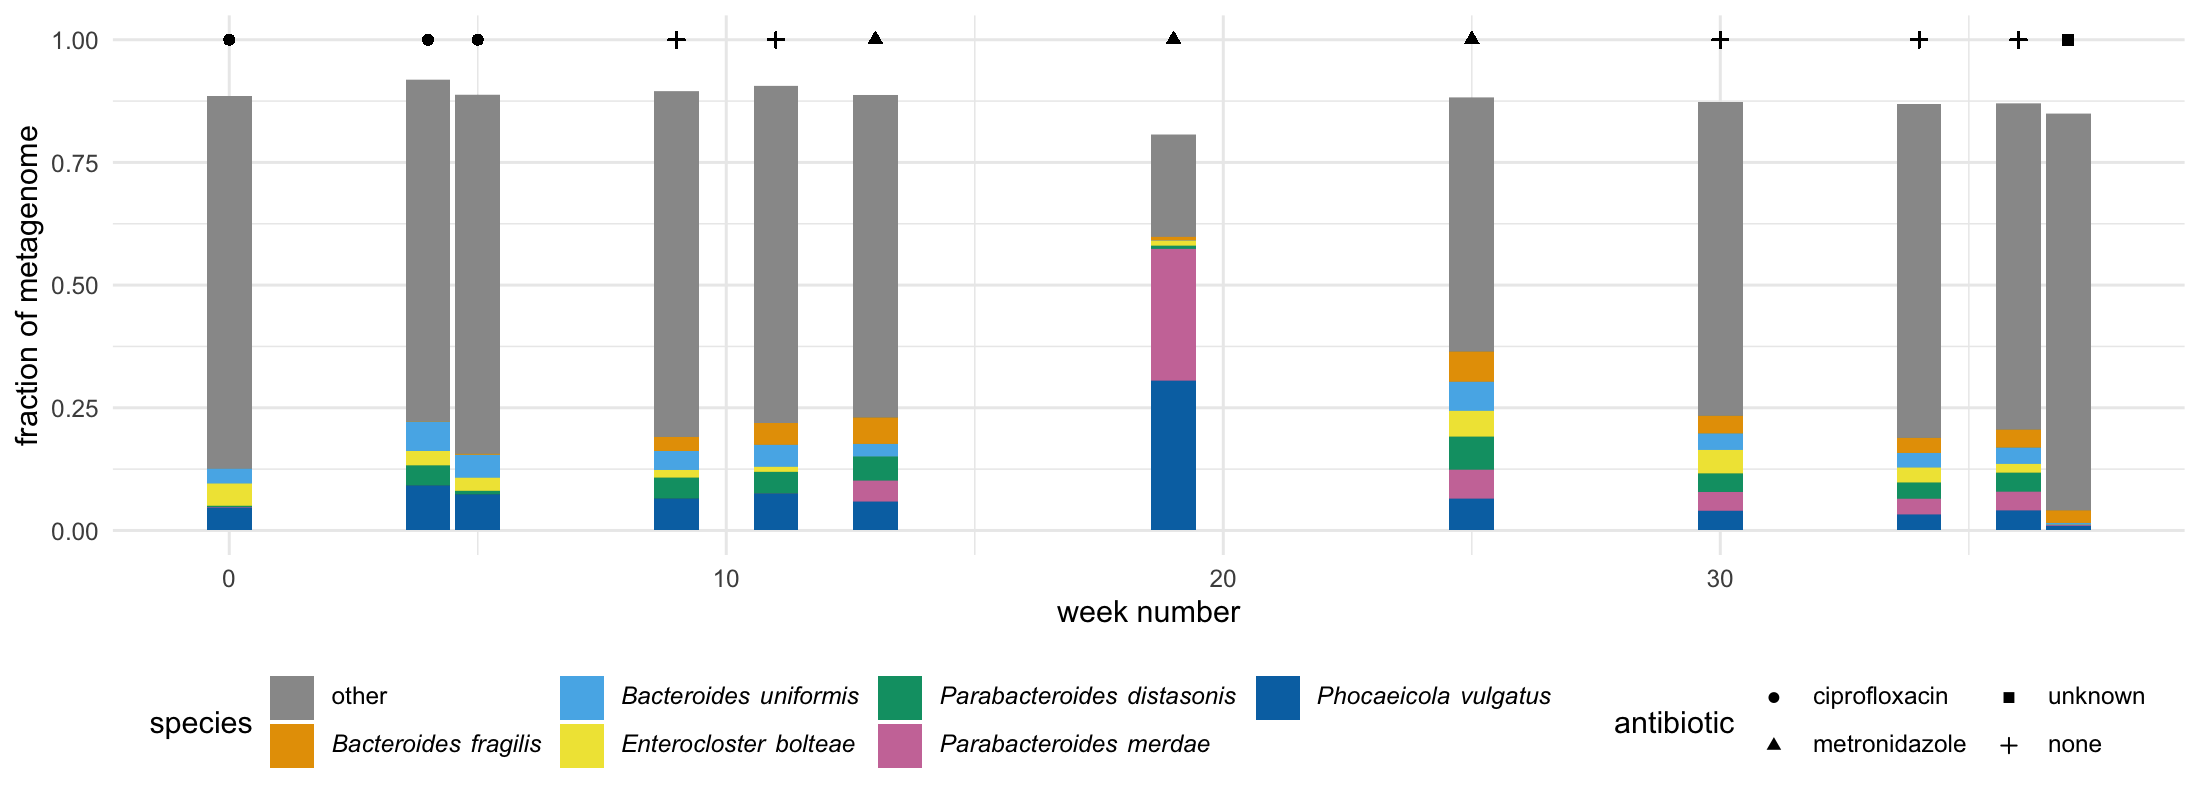

In [22]:
# adjust plot size rendered inline
options(repr.plot.width = 11, repr.plot.height = 4, repr.plot.res = 300)

sgc_plt

In [17]:
# grab just the legend for later
sgc_plt_lengend <- as_ggplot(get_legend(sgc_plt))
sgc_plt_no_legend <- sgc_plt + theme(legend.position = "none")

## Upset plot for shared k-mer content between different metapangenome construction methods

In [23]:
acc_dbs <- c("GCA_000162535.1-s__Parabacteroides_distasonis",
             "GCF_003433765.1-s__Enterocloster_bolteae",
             "GCF_003458955.1-s__Bacteroides_fragilis",   
             "GCF_003475305.1-s__Parabacteroides_merdae",
             "GCF_009020325.1-s__Bacteroides_uniformis",
             "GCF_009025805.1-s__Phocaeicola_vulgatus")

In [25]:
upset_df_combined <- data.frame()
for(acc_db in acc_dbs){
  metabat <- read_csv(paste0("outputs/metabat2_prokka_sigs_all/", acc_db, "_all_kmers.csv"),
                      col_names = c("metabat"), skip = 1, show_col_types = F)
  kmers <- read_csv(paste0("outputs/nbhd_sigs_species_all/", acc_db, "_all_kmers.csv"),
                    col_names = "kmers", skip = 1, show_col_types = F)
  roary <- read_csv(paste0("outputs/roary_sigs_all/", acc_db, "_pan_genome_reference_all_genes.csv"),
                    col_names = "roary", skip = 1, show_col_types = F)
  upset_df <- UpSetR::fromList(list("de novo" = metabat$metabat,
                                    "kaa-mer" = kmers$kmers,
                                    "reference" = roary$roary))
  upset_df$species <- acc_db
  upset_df_combined <- bind_rows(upset_df_combined, upset_df)
}

In [26]:
# edit species labels
upset_df_combined <- upset_df_combined %>%
  mutate(species = gsub(".*s__", "", species),
         species = gsub("_", " ", species),
         species = factor(species, levels = c('Bacteroides fragilis',
                                              'Bacteroides uniformis',
                                              'Enterocloster bolteae',
                                              'Parabacteroides distasonis',
                                              'Parabacteroides merdae',
                                              'Phocaeicola vulgatus')))

In [30]:
conditions <- c("de novo", "kaa-mer", "reference")
upset <- upset(upset_df_combined, intersect = conditions,
               labeller = function(x){ifelse(x != "kaa-mer", x, expression(k[aa]-mer))},
               #set_sizes=(upset_set_size() + theme(axis.text.x=element_text(angle=90))),
               set_sizes = FALSE,
               base_annotations = list("intersection size" = intersection_size(
                 counts = FALSE, mapping=aes(fill = species)) +
                   scale_fill_manual(values = c("#E69F00", "#56B4E9", "#F0E442", "#009E73", "#CC79A7", "#0072B2")) +
                   theme_classic() +
                   theme(axis.text.x = element_blank(),
                         axis.title.x = element_blank(),
                         axis.ticks.x = element_blank(),
                         legend.text = element_text(face = "italic"),
                         legend.position = "none"))) +
  theme(panel.grid = element_blank(),
        axis.title.x = element_blank())


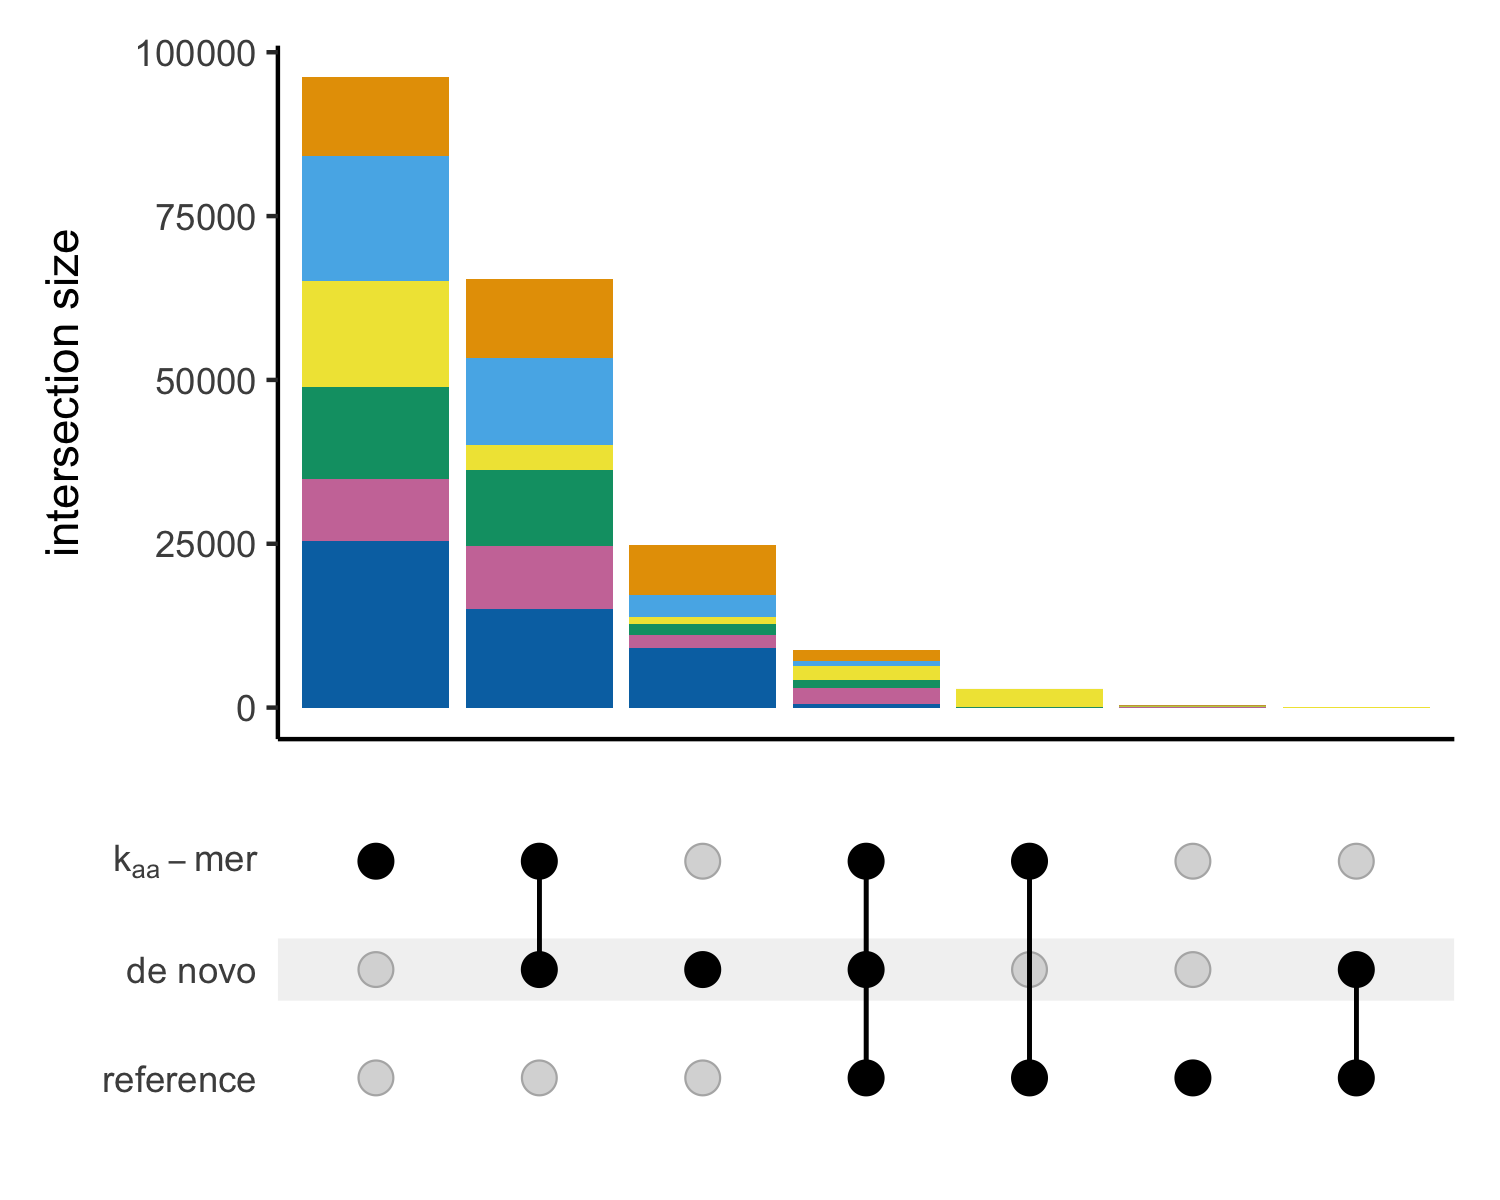

In [29]:
# adjust plot size rendered inline
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)

upset

## Comparing nucleotide to amino acid mapping rates

### Nucleotide

In [31]:
# determine the number of starting reads
starting_reads <- Sys.glob("outputs/orpheum_species_map/00_roary_nucleotide/*stat") %>%
  set_names() %>%
  map_dfr(read_tsv, col_names = c("stat", "total_reads", "comment"), col_types = "cc", .id = "sample") %>%
  mutate(total_reads = as.numeric(gsub("\t.*", "", total_reads))) %>%
  mutate(sample = basename(sample),
         sample = gsub("\\.stat", "", sample)) %>%
  separate(sample, into = c("tmp", "species"), sep = "-s__") %>%
  separate(tmp, into = c("sample", "accession"), sep = "-") %>%
  mutate(stat = gsub(":", "", stat)) %>%
  filter(stat %in% c("raw total sequences")) %>%
  select(-stat)

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning mess

In [32]:
# read in nucleotide mapping info
roary_nucleotide <- Sys.glob("outputs/orpheum_species_map/00_roary_nucleotide/*stat") %>%
  set_names() %>%
  map_dfr(read_tsv, col_names = c("stat", "value", "comment"), col_types = "cc", .id = "sample") %>%
  mutate(value = as.numeric(gsub("\t.*", "", value))) %>%
  mutate(sample = basename(sample),
         sample = gsub("\\.stat", "", sample),
         set = "roary") %>%
  separate(sample, into = c("tmp", "species"), sep = "-s__") %>%
  separate(tmp, into = c("sample", "accession"), sep = "-") %>%
  mutate(stat = gsub(":", "", stat)) %>%
  filter(stat %in% c("reads mapped"))

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning mess

In [33]:
metabat_nucleotide <- Sys.glob("outputs/orpheum_species_map/02_metabat_nucleotide/*stat") %>%
  set_names() %>%
  map_dfr(read_tsv, col_names = c("stat", "value", "comment"), col_types = "cc", .id = "sample") %>%
  mutate(value = as.numeric(gsub("\t.*", "", value))) %>%
  mutate(sample = basename(sample),
         sample = gsub("\\.stat", "", sample),
         set = "metabat") %>%
  separate(sample, into = c("tmp", "species"), sep = "-s__") %>%
  separate(tmp, into = c("sample", "accession"), sep = "-") %>%
  mutate(stat = gsub(":", "", stat)) %>%
  filter(stat %in% c("reads mapped", "reads unmapped"))

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning mess

In [34]:
nucleotide <- bind_rows(roary_nucleotide, metabat_nucleotide) %>%
  left_join(starting_reads) %>%
  mutate(set = ifelse(stat == "reads unmapped", "kaa-mer", set)) %>%
  mutate(fraction = value / total_reads) %>%
  mutate(type = "nucleotide")

Joining, by = c("sample", "accession", "species")


### Amino acid

In [35]:
# read in amino acid mapping info
roary_aa <- Sys.glob("outputs/orpheum_species_map/00_roary_aminoacid/*stat") %>%
  set_names() %>%
  map_dfr(read_tsv, col_names = c("stat", "value", "comment"), col_types = "cc", .id = "sample") %>%
  mutate(value = as.numeric(gsub("\t.*", "", value))) %>%
  mutate(sample = basename(sample),
         sample = gsub("\\.stat", "", sample),
         set = "roary") %>%
  separate(sample, into = c("tmp", "species"), sep = "-s__") %>%
  separate(tmp, into = c("sample", "accession"), sep = "-") %>%
  mutate(stat = gsub(":", "", stat)) %>%
  filter(stat %in% c("reads mapped"))

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning mess

In [36]:
metabat_aa <- Sys.glob("outputs/orpheum_species_map/02_metabat_aminoacid/*stat") %>%
  set_names() %>%
  map_dfr(read_tsv, col_names = c("stat", "value", "comment"), col_types = "cc", .id = "sample") %>%
  mutate(value = as.numeric(gsub("\t.*", "", value))) %>%
  mutate(sample = basename(sample),
         sample = gsub("\\.stat", "", sample),
         set = "metabat") %>%
  separate(sample, into = c("tmp", "species"), sep = "-s__") %>%
  separate(tmp, into = c("sample", "accession"), sep = "-") %>%
  mutate(stat = gsub(":", "", stat)) %>%
  filter(stat %in% c("reads mapped", "reads unmapped"))

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning mess

In [37]:
aa <- bind_rows(roary_aa, metabat_aa) %>%
  left_join(starting_reads) %>%
  mutate(set = ifelse(stat == "reads unmapped", "kaa-mer", set)) %>%
  mutate(fraction = value / total_reads) %>%
  mutate(type = "amino acid")

Joining, by = c("sample", "accession", "species")


In [38]:
# combine all mapping info
all <- bind_rows(nucleotide, aa)%>%
  mutate(type = factor(type, levels = c("nucleotide", "amino acid")),
         line_label = paste0(sample, "-", species))

In [39]:
# stats for paper
all %>%
  group_by(set, type) %>%
  summarize(mean_fraction = mean(fraction),
            sd_fraction = sd(fraction))

`summarise()` has grouped output by 'set'. You can override using the `.groups` argument.


set,type,mean_fraction,sd_fraction
<chr>,<fct>,<dbl>,<dbl>
kaa-mer,nucleotide,0.070577556,0.122880159
kaa-mer,amino acid,0.053773022,0.120162402
metabat,nucleotide,0.007775299,0.013704003
metabat,amino acid,0.004741979,0.004567076
roary,nucleotide,0.921647145,0.124070198
roary,amino acid,0.940780313,0.119431480


In [40]:
# t test for paper
tmp <- all %>% 
  filter(set == "roary") %>%
  select(sample, species, fraction, type) %>%
  pivot_wider(id_cols = c(sample, species), names_from = type, values_from = fraction)
t.test(tmp$`amino acid`, tmp$nucleotide, paired = T)


	Paired t-test

data:  tmp$`amino acid` and tmp$nucleotide
t = 4.2785, df = 71, p-value = 5.778e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.01021633 0.02805001
sample estimates:
mean of the differences 
             0.01913317 


In [41]:
all_tmp <- all %>%
  group_by(species, set, type) %>%
  summarize(mean_fraction = mean(fraction)) %>%
  arrange(desc(mean_fraction)) %>%
  mutate(mean_fraction_label = ifelse(set %in% c("kaa-mer", "roary"), round(mean_fraction, digits = 2), NA),
         species = gsub("_", " ", species))

`summarise()` has grouped output by 'species', 'set'. You can override using the `.groups` argument.


In [42]:
map_plt <- ggplot(all_tmp, aes(x = type, y = mean_fraction, fill = set, label = mean_fraction_label)) +
  geom_col() +
  theme_minimal() +
  theme(strip.text = element_text(face = "italic"),
        legend.position = "right") +
  facet_wrap(~species, nrow = 1) +
  geom_text(position = position_stack(vjust = .5), size = 3) +
  labs(x = "mapping alphabet", y = "mean fraction mapped", fill = "set") +
  scale_fill_brewer(palette = "Set3", labels = c(expression(k[aa]-mer), "de novo", "reference"))

Warning message:
“Removed 12 rows containing missing values (geom_text).”


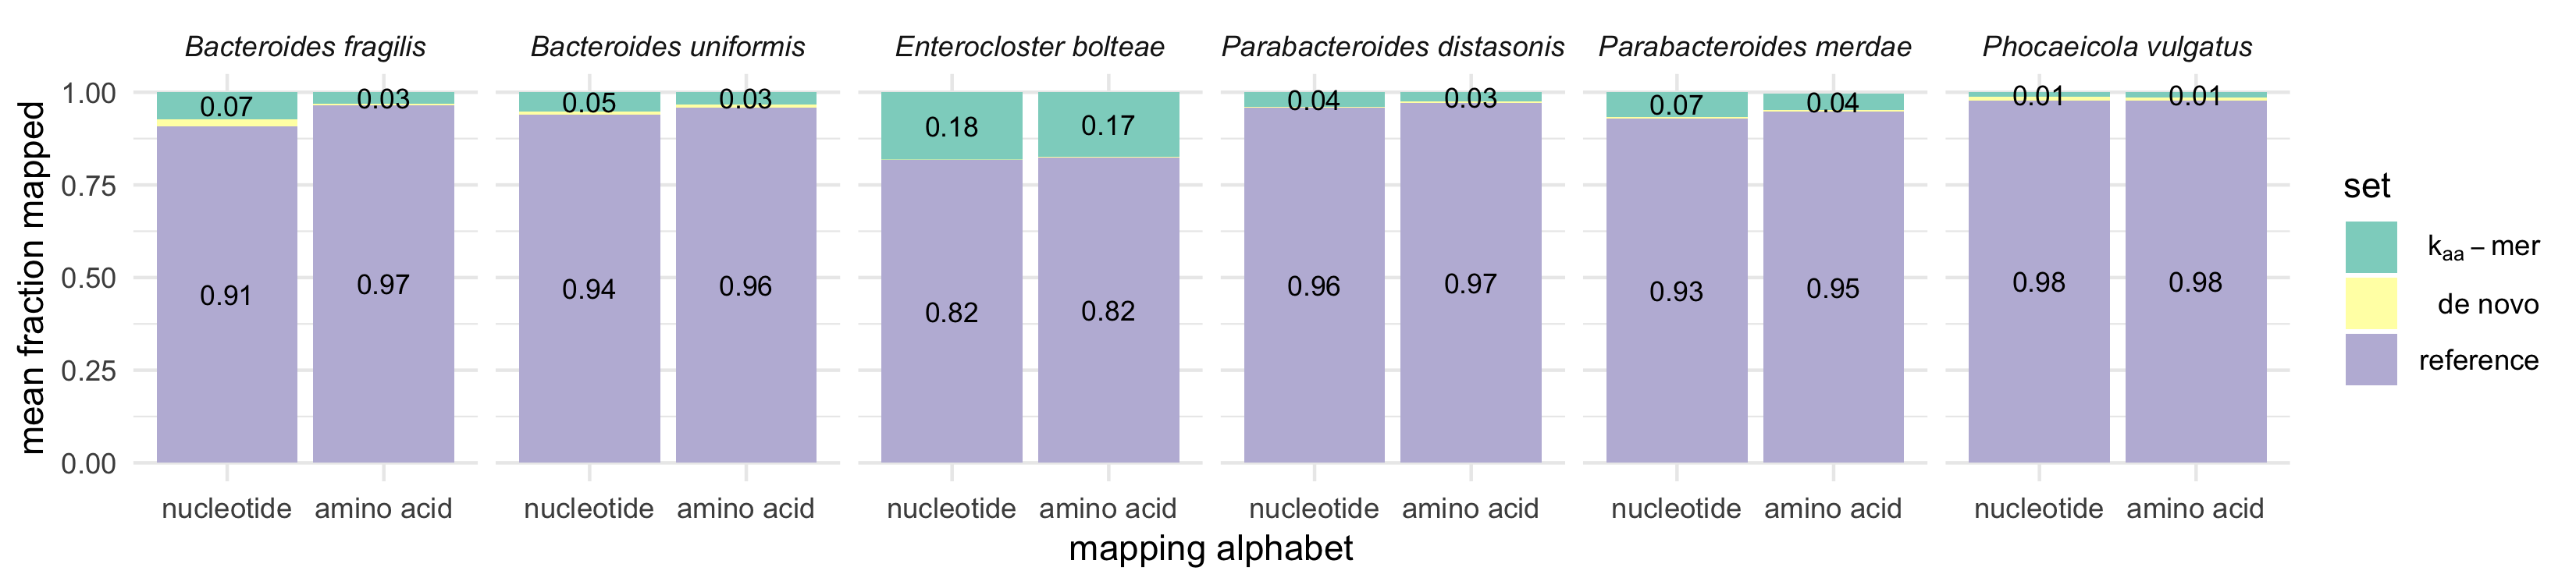

In [48]:
# adjust plot size rendered inline
options(repr.plot.width = 11, repr.plot.height = 2.5, repr.plot.res = 300)

map_plt

## Strain switching plots

### *Parabacteroides distasonis*

In [51]:
pdist_nbhd_gather <- Sys.glob("outputs/nbhd_species_gather/*GCA_000162535.1*csv") %>%
  map_dfr(read_csv, col_types = "dddddlllcccddddcccd") %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop") %>%
  mutate(sample = basename(query_filename)) %>%
  mutate(sample = gsub("-.*", "", sample))

pdist_nbhd_gather <- left_join(pdist_nbhd_gather, gtdb_lineages, by = c("accession" = "ident")) %>%
  left_join(h4017, by = c("sample" = "data_id"))

pdist_nbhd_gather2 <- pdist_nbhd_gather %>% 
  filter(! week_num %in% c(0, 5, 19, 37)) %>%
  mutate(label = ifelse(f_unique_to_query > 0.03, name, "other")) %>%
  mutate(label = ifelse(str_detect(string = label, pattern = "Parabacteroides"), label, "other")) %>%
  mutate(label = ifelse(str_detect(string = label, pattern = "merdae"), "other", label)) %>%
  mutate(label = ifelse(label == "other", label, str_extract(label, "strain=.* ")),
         label = gsub(",", "", label),
         label = gsub("strain=", "", label))

In [52]:
pdist_plt <- ggplot(pdist_nbhd_gather2, 
       aes(x = as.factor(week_num), y = f_unique_weighted, fill = label)) + 
  geom_col() +
  theme_classic() + 
  scale_fill_manual(values = c("#4E79A7", "#D7B5A6", "#E15759", "#FABFD2", "#FFBE7D", "#BAB0AC")) +
  theme(legend.position = "bottom",
        legend.title = element_blank(),
        axis.title.y = element_blank(),
        plot.title = element_text(face = "italic", size = 9)) +
  guides(fill=guide_legend(nrow=3)) +
  labs(x = "week number", y = "weighted unique fraction",
       title = "Parabacteroides distasonis")

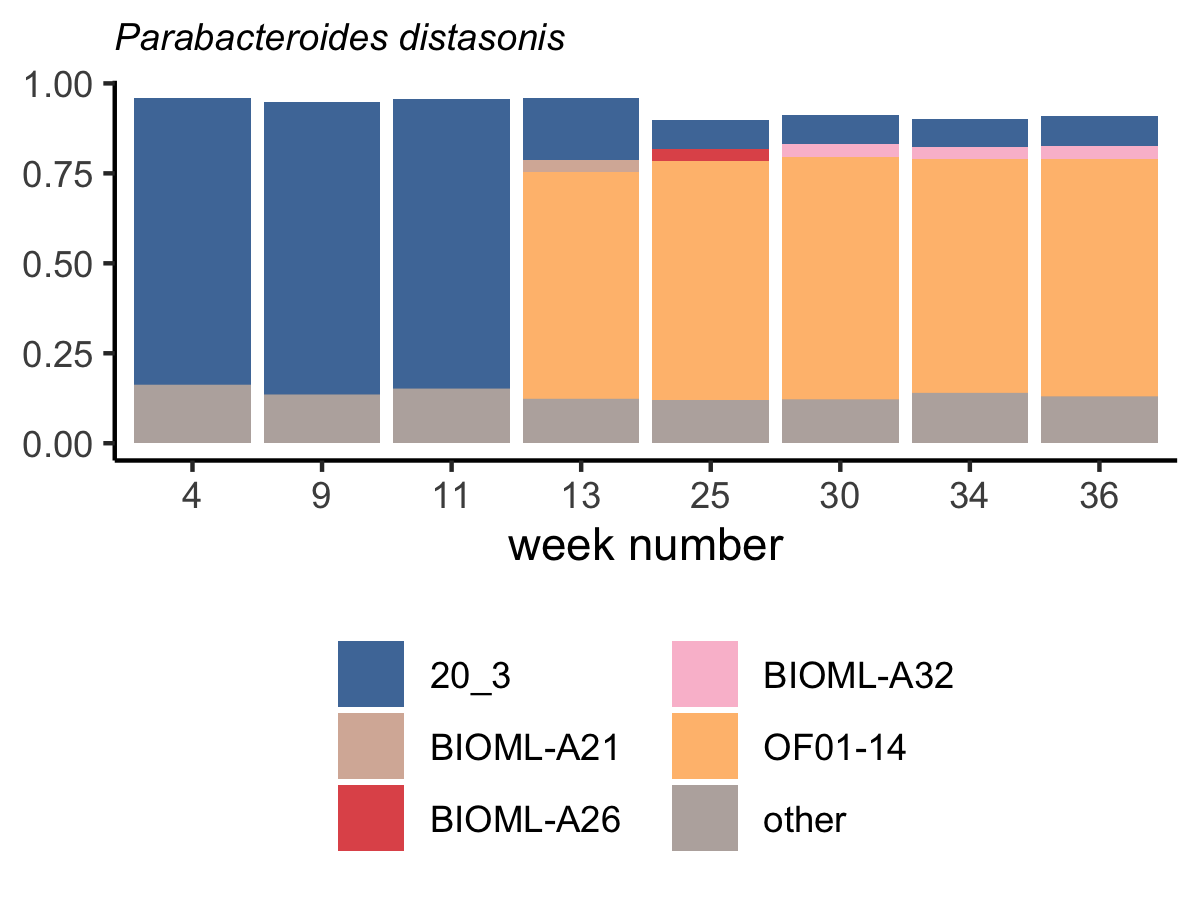

In [62]:
# adjust plot size rendered inline
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)


pdist_plt

### *Phocaeicola vulgatus*

In [56]:
pvulg_nbhd_gather <- Sys.glob("outputs/nbhd_species_gather/*GCF_009025805.1*csv") %>%
  map_dfr(read_csv, col_types = c("dddddlllcccddddcccd")) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop") %>%
  mutate(sample = basename(query_filename)) %>%
  mutate(sample = gsub("-.*", "", sample))

pvulg_nbhd_gather <- left_join(pvulg_nbhd_gather, gtdb_lineages, by = c("accession" = "ident")) %>%
  left_join(h4017, by = c("sample" = "data_id"))

pvulg_nbhd_gather2 <- pvulg_nbhd_gather %>% 
  filter(! week_num %in% c(37)) %>%
  mutate(label = ifelse(f_unique_to_query > 0.03, name, "other")) %>%
  mutate(label = ifelse(str_detect(string = label, pattern = "vulgatus"), label, "other"))  %>%
  mutate(label = ifelse(label == "other", label, str_extract(label, "strain=.* ")),
         label = gsub(",", "", label),
         label = gsub("strain=", "", label),
         label = factor(label, levels = c('CFPLTA002_1B ', 'VPI-4496.2 ', 'H23 ', 'AF16-11 ', 'AM38-19 ', '1001175st1_C6 ', 'other')))

In [57]:
pvulg_plt <- ggplot(pvulg_nbhd_gather2, 
       aes(x = as.factor(week_num), y = f_unique_weighted, fill = label)) + 
  geom_col() +
  theme_classic() + 
  scale_fill_manual(values = c("#A0CBE8", "#B6992D", "#FF9D9A", "#B07AA1",  "#F1CE63",
                               "#D4A6C8", "#BAB0AC")) +
  theme(legend.position = "bottom",
        legend.title = element_blank(),
        axis.title.y = element_blank(),
        plot.title = element_text(face = "italic", size = 9)) +
  guides(fill=guide_legend(nrow=3)) + 
  ylim(0, 1) +
  labs(x = "week number", y = "weighted unique fraction",
       title = "Phocaeicola vulgatus")

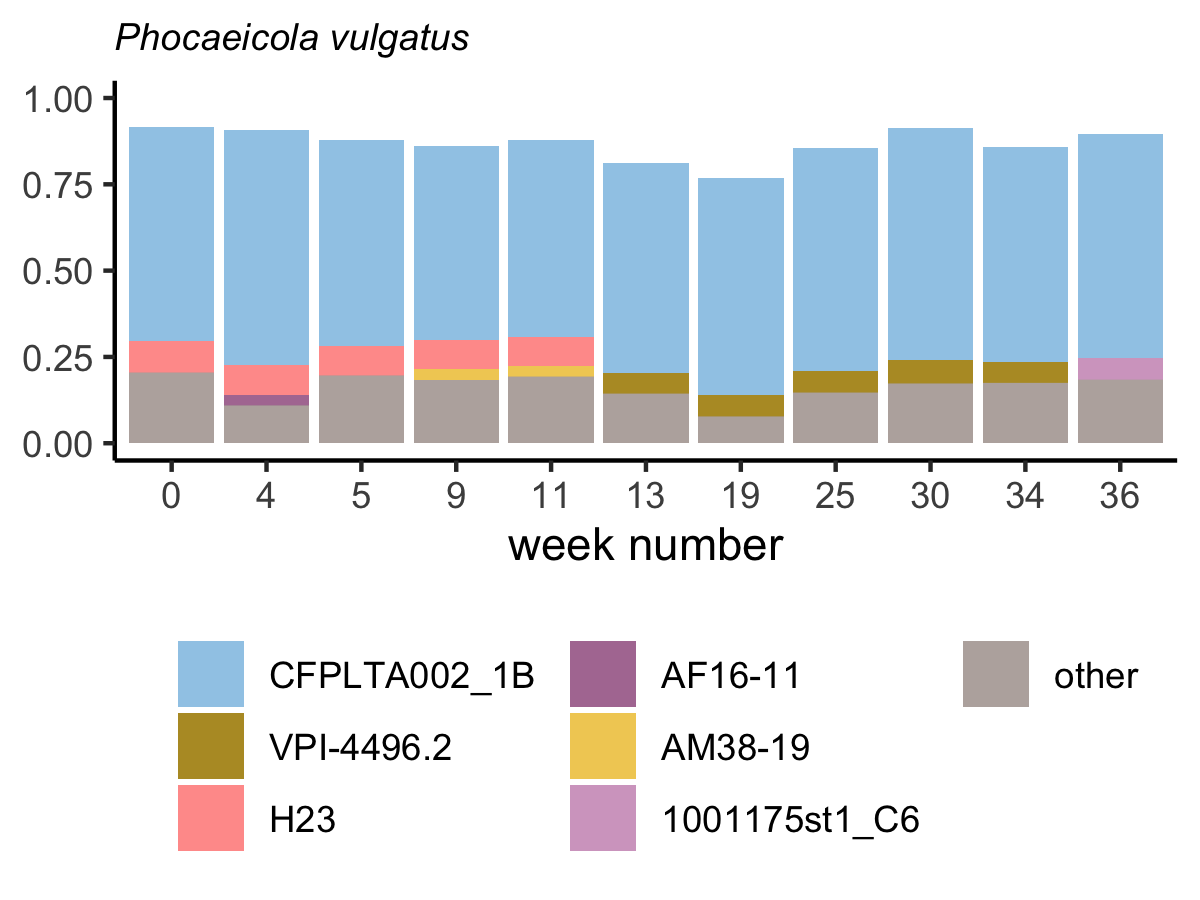

In [63]:
pvulg_plt

### *Bacteroides vulgatus*

In [59]:
buniform_nbhd_gather <- Sys.glob("outputs/nbhd_species_gather/*GCF_009020325.1*csv") %>%
  map_dfr(read_csv, col_types = c("dddddlllcccddddcccd")) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop") %>%
  mutate(sample = basename(query_filename)) %>%
  mutate(sample = gsub("-.*", "", sample))

buniform_nbhd_gather <- left_join(buniform_nbhd_gather, gtdb_lineages, by = c("accession" = "ident")) %>%
  left_join(h4017, by = c("sample" = "data_id"))

buniform_nbhd_gather2 <- buniform_nbhd_gather %>%
  filter(! week_num %in% c(19, 37)) %>%
  mutate(label = ifelse(grepl(pattern = "uniformis", name), name, "other")) %>%
  mutate(label = ifelse(f_unique_to_query > 0.03, label, "other")) %>%
  mutate(label = ifelse(label == "other", label, str_extract(label, "strain=.* ")),
         label = gsub(",", "", label),
         label = gsub("strain=", "", label))

In [60]:
buniform_plt <- ggplot(buniform_nbhd_gather2,
       aes(x = as.factor(week_num), y = f_unique_weighted, fill = label)) +
  geom_col() +
  theme_classic() +
  scale_fill_manual(values = c("#86BCB6", "9D7660", "#BAB0AC")) +
  theme(legend.position = "bottom",
        plot.title = element_text(face = "italic", size = 9),
        legend.title = element_blank()) +
  guides(fill=guide_legend(nrow=3)) +
  ylim(0, 1) +
  labs(x = "week number", y = "weighted unique fraction",
       title = "Bacteroides uniformis")

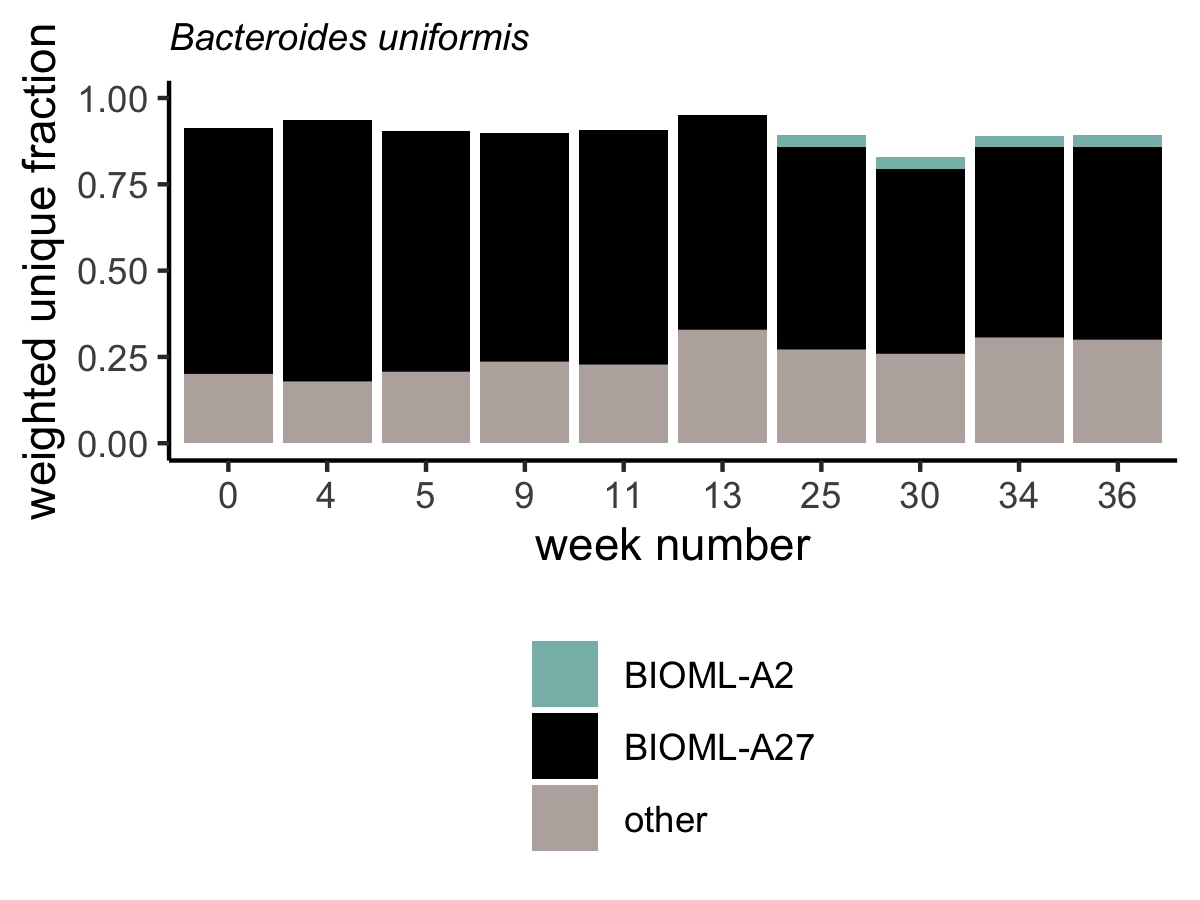

In [64]:
buniform_plt

## Combining plots

In [65]:
row1 <- ggarrange(sgc_plt_no_legend, upset)
row1_with_legend <- ggarrange(row1, sgc_plt_lengend, nrow = 2, heights = c(3, 1))
strain_plts <- ggarrange(buniform_plt, pdist_plt, pvulg_plt, ncol = 3)
rs3_fig_panel <- ggarrange(row1_with_legend, 
                           map_plt, 
                           strain_plts, 
                           nrow = 3, heights = c(3, 2, 3))

Warning message:
“Removed 12 rows containing missing values (geom_text).”


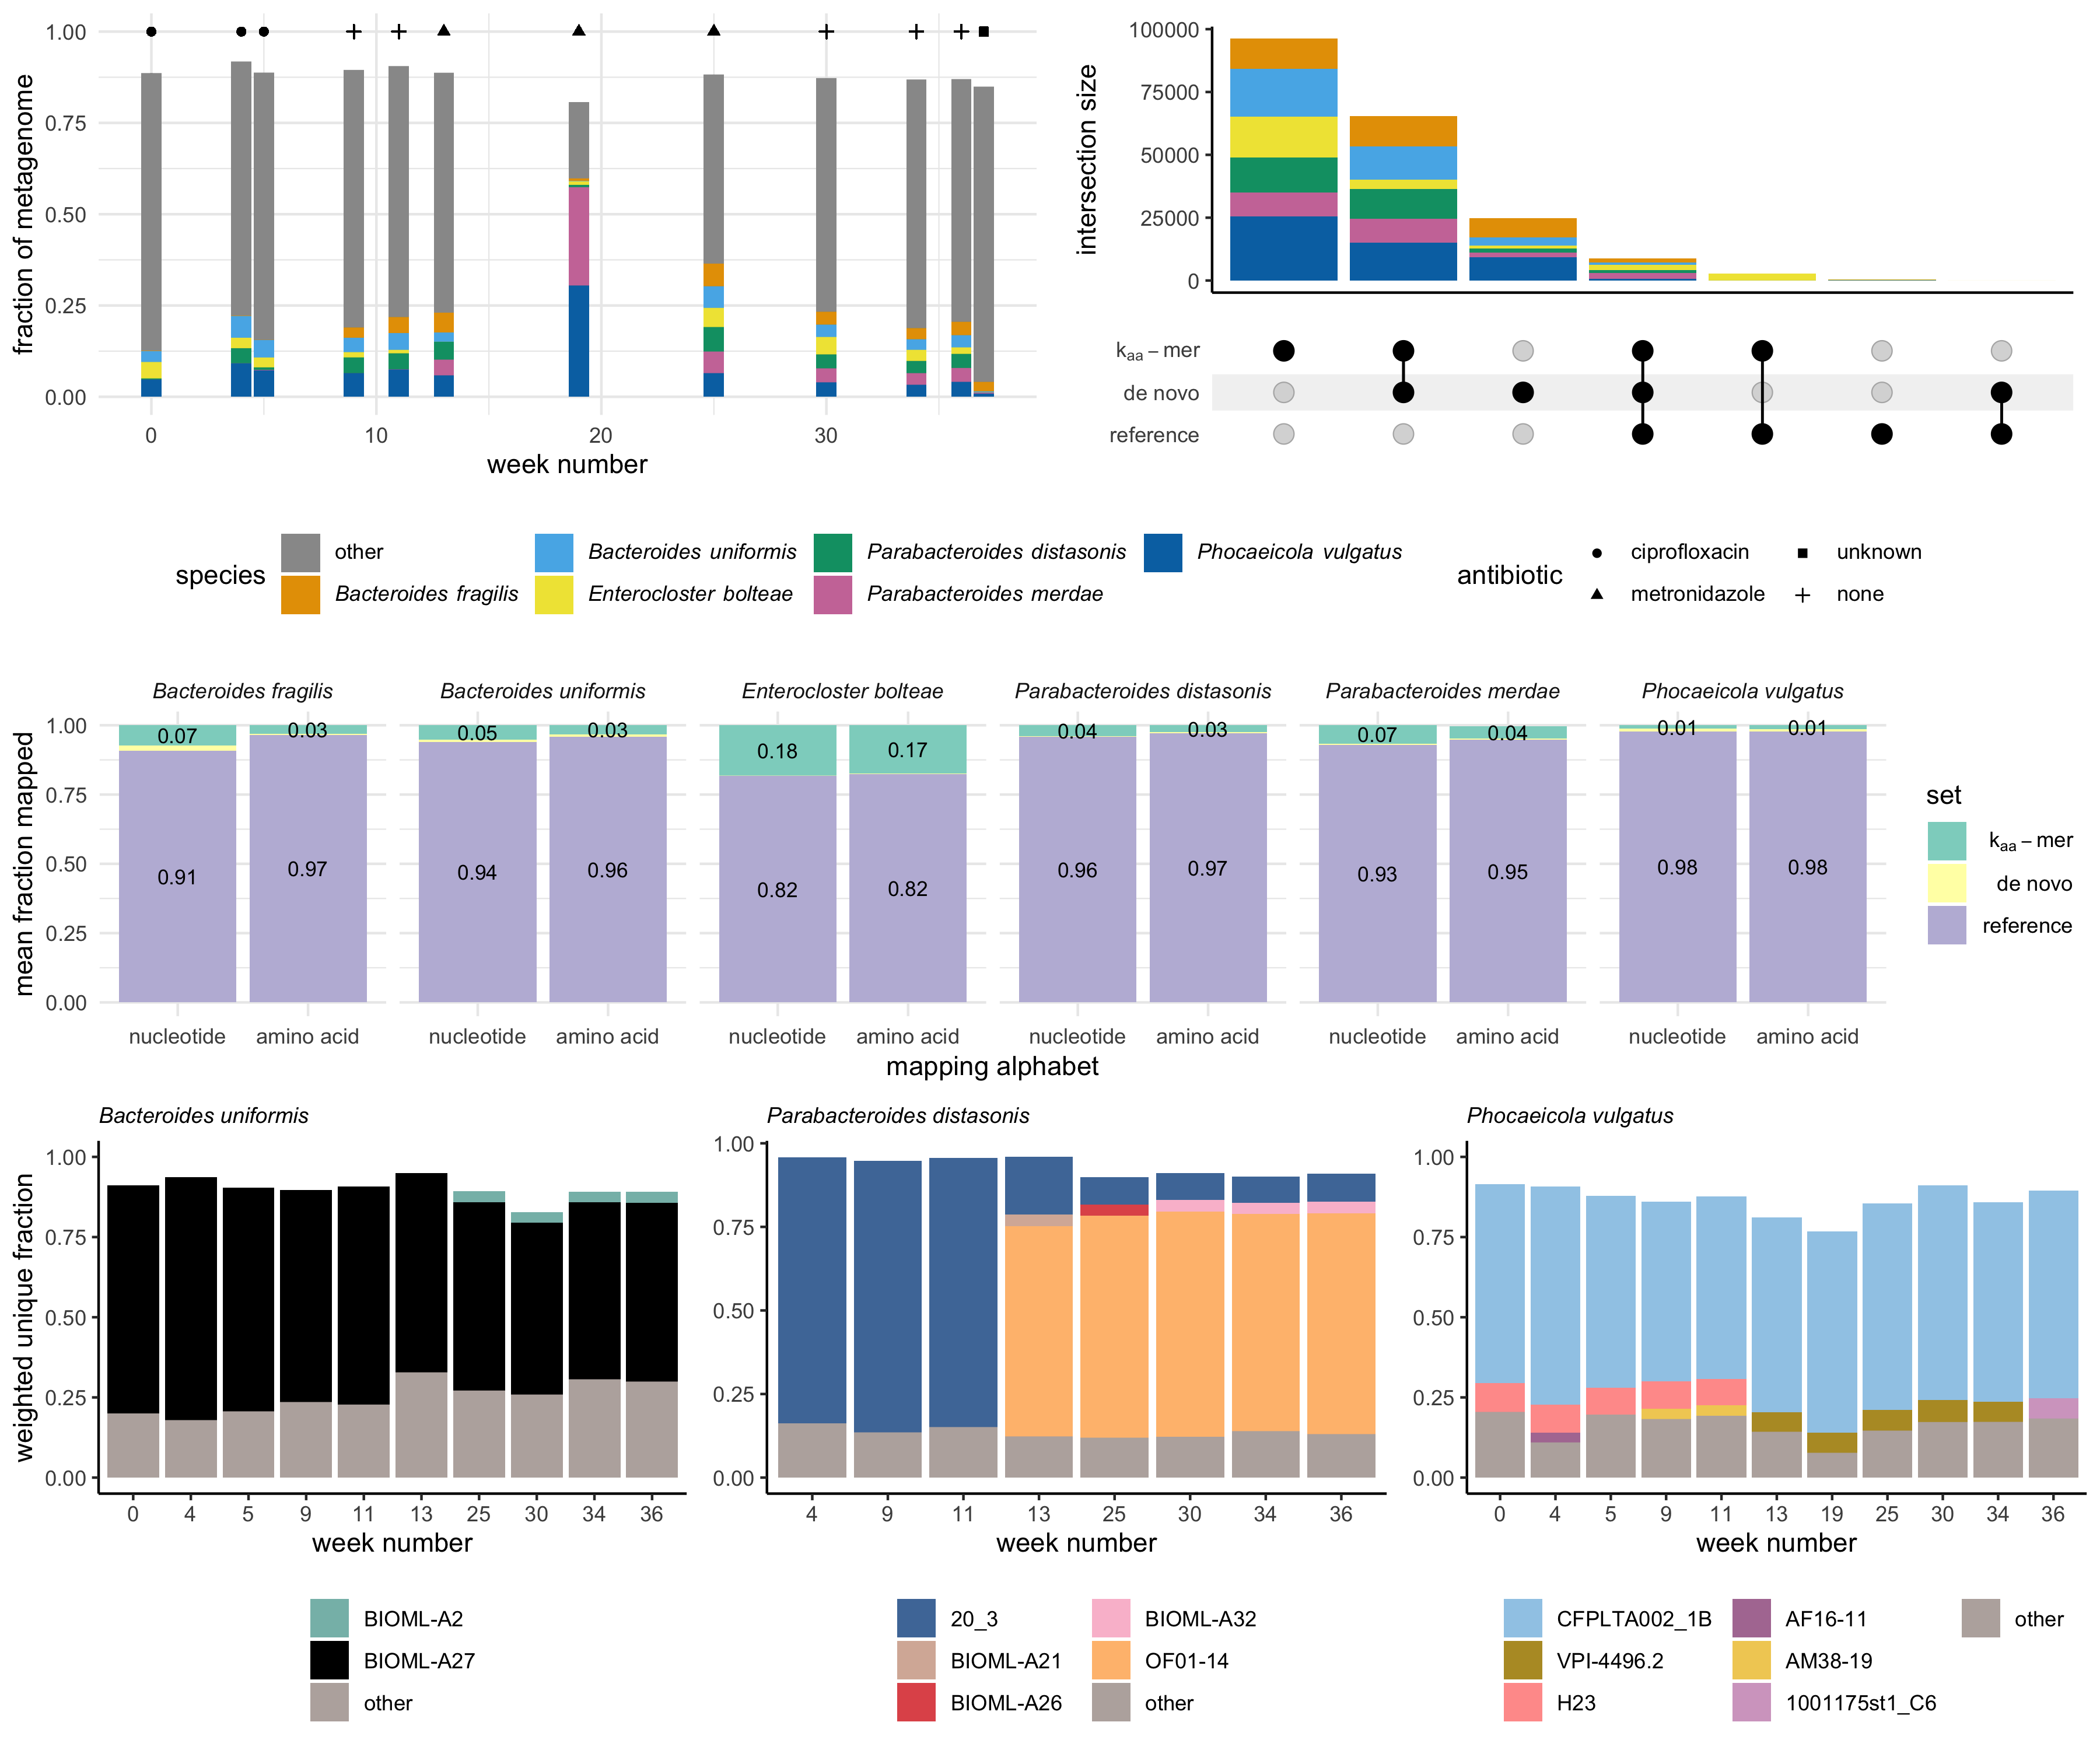

In [67]:
# adjust plot size rendered inline
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 300)

# pdf("metap_figure_panel.pdf", height = 10, width = 12)
rs3_fig_panel
# dev.off()